# Dwuosobowe gry deterministyczne

Implementacja algorytmu min-max z przycinaniem α−β. Dla różnych ruchów o tej samej jakości, algorytm zwraca losowy z nich. 

Następnie wykorzystano implementację do porównania jakości dla różnych głębokości przeszukiwania dla gry kółko i krzyżyk na planszy $N \times N$. 

W raporcie zostały umieszczone wyniki turnieju w grę kółko i krzyżyk, w którym biorą udział gracze sterowani algorytmem z różnymi głębokościami przeszukiwania.




## Używane biblioteki oraz funkcje

In [1]:
import numpy as np
from collections import Counter
from multiprocessing import Pool
import os
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import timeit
import random
import time


EMPTY = 0
CROSS = 1
CIRCLE = -1
    

In [2]:
def print_board(board):
    '''
    Prints the board
    '''
    for row in board:
        for cell in row:
            if cell == EMPTY:
                char = '.'
            elif cell == CROSS:
                char = 'x'
            elif cell == CIRCLE:
                char = 'o'
            else:
                raise ValueError('wrong value in board')
            print(char, end=' ')
        print()

In [3]:
def game_status(board):
    '''
    returns None if not a terminal state (game didn't finish), CROSS is cross player won, CIRCLE is circle player won, 0 for a tie.
    '''
  
    #Draw
    if (board != EMPTY).all():
        return 0
    
    #stacking rows, columns and diagonals in one array
    lines = np.concatenate([
        board,
        board.T,
        board[range(len(board)), range(len(board))].reshape(1, -1),
        board[range(len(board)), range(len(board) - 1, -1, -1)].reshape(1, -1),
    ])
    #Checking crosses lines win
    if ((lines == CROSS).sum(axis=1) == len(board)).any():
        return CROSS
    #Checking circles lines win
    if ((lines == CIRCLE).sum(axis=1) == len(board)).any():
        return CIRCLE
    #if not a terminal state
    return None

In [4]:
def available_game_states(board, player):
    '''
    Yields all possible boards that can be obtained by a single move of player `player`
    '''
    for i in range(board.shape[0]):  
        for j in range(board.shape[1]):
            if board[i, j] == EMPTY:
                new_state = board.copy()
                new_state[i,j] = player
                yield new_state

## Allgorytm Minimax z przycinaniem alfa-beta

In [151]:
  def mini_max_algorithm(board, depth, player, heuristic_func, move_max=True, alpha=-np.inf, beta=np.inf,
                       return_board=True, orig_player=None):
    '''
    player --> CROSS or CIRCLE
    move_max --> maximazing or minimalizing a utility value
    return_board --> return printing board
    '''
    if orig_player is None:
        orig_player = player
    
    status = game_status(board)
    
    if status is not None:
#         return heuristic_func(board, player), board
        return 2 if status == orig_player else -2 if status == -orig_player else 0, board

    if depth == 0:
        value = heuristic_func(board, orig_player)
        
        assert -1 <= value <= 1 #zakladam, że wartości heurystyki są od -1 do 1
                                #(dlatego,że wygrana to 2, a przegrana to -2, tzn
                                #sa scisle wieksze lub scisle mniejsze od wartosci heurystyki)
        return value, board
#         return heuristic_func(board, player) * (1 if orig_player == player else -1), board
    
    available_boards = available_game_states(board, player)
    if move_max:
        best_boards = []
        best_value = -np.inf
        for available_board in available_boards:
            value, _ = mini_max_algorithm(available_board, depth-1, -player, heuristic_func, not move_max, alpha, beta,
                                          return_board=False, orig_player=orig_player) 
            if best_value < value:
                #Zerowanie poprzedniej tablicy best_boards
                best_boards = [available_board]
                best_value = value
            elif best_value == value: 
                best_boards.append(available_board)
            #Pruning
            if best_value > beta or (not return_board and best_value == beta):
                return best_value, None
            
            if not return_board:
                alpha = max(alpha, best_value)
            else:
                #Potrzebne do wylosowania losowego najlepszego boarda(inaczej moze zostac odciety bez poznania dokladnej wartosci)
                #zbyt wczesne odciecie
                alpha = max(alpha, best_value - 1e-6)
            
        if not best_boards or not return_board:
            return best_value, None
        return best_value, random.choice(best_boards)
    
    else:
        best_boards = []
        best_value = np.inf
        for available_board in available_boards:
            value, _ = mini_max_algorithm(available_board, depth-1, -player, heuristic_func, not move_max, alpha, beta,
                                          return_board=False, orig_player=orig_player)
            if best_value > value:
                #Zerowanie poprzedniej tablicy best_boards
                best_boards = [available_board]
                best_value = value
            elif best_value == value: 
                best_boards.append(available_board)
            if alpha > best_value or (not return_board and alpha == best_value):
                return best_value, None
            
            if return_board:
                beta = min(best_value, beta)
            else:
                beta = min(best_value + 1e-6, beta)
            
        if not best_boards or not return_board:
            return best_value, None
        return best_value, random.choice(best_boards)

## Funkcja turniejowa play

In [90]:
def print_state(board, player=None, utility=None):
    '''
    Prints current players utlility
    '''
    if player is not None:
        print(f'Player {"X" if player == CROSS else "O"} (utility {utility})')
    print_board(board)
    print('-' * 100)
    print()

def play(depth1, depth2, heuristic_func1, heuristic_func2, board_size, initial_player=CROSS, verbose=False):
    '''
    Main tournament function
    '''
    board = np.zeros((board_size, board_size))
    player = initial_player
    if verbose:
        print_state(board)
    while (status := game_status(board)) is None:
        utility, new_board = mini_max_algorithm(board, depth1 if player == initial_player else depth2, player,
                                                heuristic_func1 if player == initial_player else heuristic_func2)
        if verbose:
            print_state(new_board, player, utility)
        board = new_board
        player = -player
    
    if verbose:
        if status != 0:
            print(f'Player {"X" if status == CROSS else "O"} won!')
        else:
            print('The game ended with a tie!')
        
    return status

def play_unpack(args):
    return play(*args)

## Funkcje heurystyczne

In [148]:
def trivial_heuristics(board, player):
    '''
    Returns a hueristics value of a board `board` for player `player`.
    Higher the better.
    Positive values indicate that `player` is at winning position,
    0 is a tie,
    and negative values indicate that `player` is at loosing position. 
    '''
    status = game_status(board)
    if status == player:
        return 1
    if status == -player:
        return -1
    return 0  

def heuristics(board, player):
    '''
    calculate the maximum number of `player` signs (cross or circle) in all lines (rows, columns or diagonals),
    assuming that there are not signs of other player in that line.
    Analogically, calculate that for the opposite player and return the difference.
    
    '''
    
    lines = np.concatenate([
        board,
        board.T,
        board[range(len(board)), range(len(board))].reshape(1, -1),
        board[range(len(board)), range(len(board) - 1, -1, -1)].reshape(1, -1),
    ])
    
    score_player = ((lines == player).sum(axis=1) * ((lines == -player).sum(axis=1) == 0)).max()
    score_opposite = ((lines == -player).sum(1) * ((lines == player).sum(1) == 0)).max()
    
    #Full by axis board 
    if score_player == len(board):
        return 1
    if score_opposite == len(board):
        return -1
    #dzielenie przez len(board) zeby znormalizowac wartosc do przedzialu (-1,1)
    return (score_player - score_opposite) / len(board)

def heuristics2(board, player):
    '''
    calculate the sum of number of `player` signs (cross or circle) in all lines (rows, columns or diagonals) squared, 
    assuming that there are not signs of other player in that line.
    Analogically, calculate that for the opposite player and return the difference.
    
    '''
    
    lines = np.concatenate([
        board,
        board.T,
        board[range(len(board)), range(len(board))].reshape(1, -1),
        board[range(len(board)), range(len(board) - 1, -1, -1)].reshape(1, -1),
    ])
    
    score_player = (((lines == player).sum(1) * ((lines == -player).sum(1) == 0)) ** 2).sum()
    score_opposite = (((lines == -player).sum(1) * ((lines == player).sum(1) == 0)) ** 2).sum()
    
    #Full by axis board 
    if score_player == len(board):
        return 1
    if score_opposite == len(board):
        return -1
    
    #dzielenie zeby znormalizowac wartosc do przedzialu (-1,1)
    return (score_player - score_opposite) / (len(board) ** 2 * (len(board) * 2 + 2))

## Przykładowe wyniki turniejowe dla gry kółko krzyżyk 

In [55]:
play(depth1=2, depth2=4, heuristic_func1=trivial_heuristics, heuristic_func2=trivial_heuristics, board_size=5, verbose=True)

. . . . . 
. . . . . 
. . . . . 
. . . . . 
. . . . . 
----------------------------------------------------------------------------------------------------

Player X (utility 0)
. . . . . 
. . . . . 
. . x . . 
. . . . . 
. . . . . 
----------------------------------------------------------------------------------------------------

Player O (utility 0)
. . . . . 
. . . . . 
o . x . . 
. . . . . 
. . . . . 
----------------------------------------------------------------------------------------------------

Player X (utility 0)
. . . . . 
. . . . x 
o . x . . 
. . . . . 
. . . . . 
----------------------------------------------------------------------------------------------------

Player O (utility 0)
. . . . . 
. . . . x 
o . x . . 
. . . . . 
. . . o . 
----------------------------------------------------------------------------------------------------

Player X (utility 0)
. . . . . 
. . . . x 
o . x x . 
. . . . . 
. . . o . 
-------------------------------------------------------

0

*Przykładowa gra kółko-krzyżyk na planszy 5x5. Podczas całej rozgrywki zarówno jak dla gracza pierwszego jak i drugiego aktualna pozycja oraz "Użytek" z wygrania wynosiła zero.*

In [136]:
play(2, 5, trivial_heuristics, heuristics, board_size=4, verbose=True)

. . . . 
. . . . 
. . . . 
. . . . 
----------------------------------------------------------------------------------------------------

Player X (utility 0)
. . . . 
. . x . 
. . . . 
. . . . 
----------------------------------------------------------------------------------------------------

Player O (utility 0)
. . . . 
. o x . 
. . . . 
. . . . 
----------------------------------------------------------------------------------------------------

Player X (utility 0)
. . . . 
. o x . 
. . . . 
x . . . 
----------------------------------------------------------------------------------------------------

Player O (utility 0)
. . o . 
. o x . 
. . . . 
x . . . 
----------------------------------------------------------------------------------------------------

Player X (utility 0)
. x o . 
. o x . 
. . . . 
x . . . 
----------------------------------------------------------------------------------------------------

Player O (utility 0)
. x o o 
. o x . 
. . . . 
x . . . 
----------

0

***Wnioski***

Dla wybranych heurystyk przy zwiększaniu głębokości dla jednej z nich, w kazdym przypadku uzyskujemy remis. Gra zakończona na remisie jest najbardziej prawdopodobna w tym przypadku.

In [137]:
play(np.inf, 5, trivial_heuristics, heuristics, board_size=3, verbose=True)

. . . 
. . . 
. . . 
----------------------------------------------------------------------------------------------------

Player X (utility 0)
. . . 
. x . 
. . . 
----------------------------------------------------------------------------------------------------

Player O (utility 0)
. o . 
. x . 
. . . 
----------------------------------------------------------------------------------------------------

Player X (utility inf)
. o . 
. x . 
. . x 
----------------------------------------------------------------------------------------------------

Player O (utility -inf)
. o . 
. x o 
. . x 
----------------------------------------------------------------------------------------------------

Player X (utility inf)
. o . 
. x o 
x . x 
----------------------------------------------------------------------------------------------------

Player O (utility -inf)
. o . 
o x o 
x . x 
----------------------------------------------------------------------------------------------------

Pla

1

**Wnioski**

Brak korzystania z heurystyki, gracz pierwszy osiąga stan terminalny, korzyść dla gracza pierwszego (gracz X). Głębokość przeszukiwania ma znaczenie, niezależnie od używanej heurystyki.

In [143]:
play(5, np.inf, trivial_heuristics, heuristics, board_size=3, verbose=True)

. . . 
. . . 
. . . 
----------------------------------------------------------------------------------------------------

Player X (utility 0)
. . . 
. . x 
. . . 
----------------------------------------------------------------------------------------------------

Player O (utility 0)
. . . 
. o x 
. . . 
----------------------------------------------------------------------------------------------------

Player X (utility 0)
. . . 
x o x 
. . . 
----------------------------------------------------------------------------------------------------

Player O (utility inf)
. . . 
x o x 
. . o 
----------------------------------------------------------------------------------------------------

Player X (utility -inf)
. . x 
x o x 
. . o 
----------------------------------------------------------------------------------------------------

Player O (utility inf)
. . x 
x o x 
o . o 
----------------------------------------------------------------------------------------------------

Player

-1

**Wnioski**

Wygrana gracza drugiego przy osiągnieciu stanu terminalnego, głębokość przeszukiwania nadal ma znaczenie.

### Wykres przedstawiajacy zależność czasową od głębokości przeszukiwań oraz rozmiaru planszy

In [113]:
depths = list(range(1, 5))
sizes = list(range(3, 25))
durations = np.zeros((len(depths), len(sizes)), dtype=np.float64) * np.nan
for i, depth in enumerate(depths):
    for j, size in enumerate(sizes):
        durations[i, j] = timeit.timeit(lambda: play(depth, depth, heuristics, heuristics, size), number=1)
        if durations[i, j] > 20:
            break

Text(123.0, 0.5, 'depth')

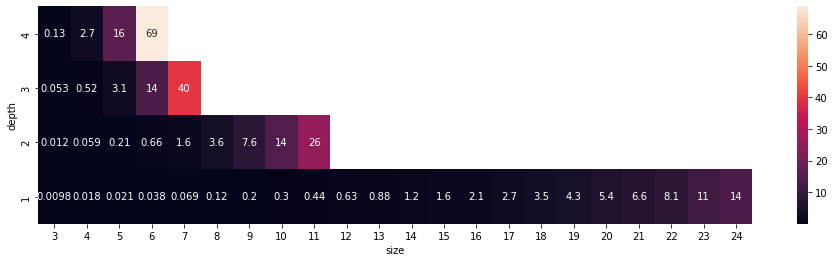

In [115]:
plt.figure(figsize=(16, 4))
sns.heatmap(durations[::-1], annot=True, xticklabels=sizes, yticklabels=depths[::-1])
plt.xlabel('size')
plt.ylabel('depth')

Text(0, 0.5, 'duration (s)')

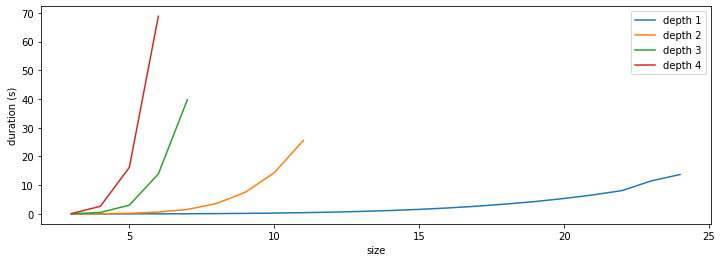

In [116]:
plt.figure(figsize=(12, 4))
for i, depth in enumerate(depths):
    sns.lineplot(y=durations[i], x=sizes)
plt.legend([f'depth {depth}' for depth in depths])
plt.xlabel('size')
plt.ylabel('duration (s)')

***Wnioski***

Złożoność obliczeniowa jest w postaci $(size^2)^{depth}$ jednego algorytmu minimaxa. Dla głębokości równej jeden można zaoobserować kształt funkcji kwadratowej. Szybkość narastania funkcji dla wszystkich głębokości jest szybsza niż liniowa. Im większa głębkość tym funkcja szybciej rośnie.


### Funkcje słupkowe

In [9]:
def barplot(dictionary, disp=False):
    res = {'first': [], 'second': [], 'tie': [], 'index': []}
    for key, value in dictionary.items():
        res['first'].append(value.count(1))
        res['second'].append(value.count(-1))
        res['tie'].append(value.count(0))
        res['index'].append(key)
        
    df = pd.DataFrame.from_dict(res).set_index('index')
    df.plot(kind='bar', stacked=True)
    for x, t in enumerate(df.itertuples()):
        plt.text(x, t.first / 2, f'{t.first / (t.first + t.second + t.tie) * 100:.1f}%', 
                 va='center', ha='center', fontsize=8)
        plt.text(x, t.first + t.second / 2, f'{t.second / (t.first + t.second + t.tie) * 100:.1f}%', 
                 va='center', ha='center', fontsize=8)
        plt.text(x, t.first + t.second + t.tie / 2, f'{t.tie / (t.first + t.second + t.tie) * 100:.1f}%', 
                 va='center', ha='center', fontsize=8)
    if disp:
        display(df)

In [10]:
def pool_initializer():
    np.random.seed((os.getpid() * int(time.time())) % 123456789)
    random.seed((os.getpid() * int(time.time())) % 123456789)

In [14]:
THREADS = 24
REPS = 128

In [15]:
def plotting_depth_of_fun1(fun1, fun2, size, max_depth1, depth2=1, disp=False):
    with Pool(THREADS, initializer=pool_initializer) as pool:
        res = {}
        for i in range(1, max_depth1 + 1):
            res[i] = pool.map(play_unpack, 
                [(i, depth2, fun1, fun2, size) for _ in range(REPS)])
        
    barplot(res, disp=disp) 

def plotting_depth_of_fun2(fun1, fun2, size, max_depth2, depth1=1, disp=False):
    with Pool(THREADS, initializer=pool_initializer) as pool:
        res = {}
        for i in range(1, max_depth2 + 1):
            res[i] = pool.map(play_unpack, 
                [(depth1, i, fun1, fun2, size) for _ in range(REPS)])
        
    barplot(res, disp=disp)
    
def plotting_depth_symetric(fun1, fun2, size, max_depth1, depth2=1, disp=False):
    with Pool(THREADS, initializer=pool_initializer) as pool:
        res = {}
        for i in range(1, max_depth1 + 1):
            a = pool.map(play_unpack, 
                [(i, depth2, fun1, fun2, size) for _ in range(REPS // 2)])
            b = pool.map(play_unpack, 
                [(depth2, i, fun2, fun1, size) for _ in range(REPS // 2)])
            res[i] = a + [-x for x in b]
        
    barplot(res, disp=disp)

### Wyniki słupkowe przeprowadzone dla 128 gier dla planszy 3x3

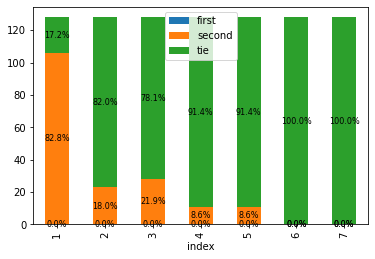

In [152]:
plotting_depth_of_fun1(trivial_heuristics, trivial_heuristics, size=3, max_depth1=7, depth2=7)

**WNIOSKI**

Dla zwiększającej się głębokości gracza pierwszego (Krzyżyk) oraz stałej głebokości gracza drugiego (7), przy korzystaniu z tych samym heurystyk, zauważyc można przewagę gracza drugiego przy początkowych iteracjach po głębkości gracza pierwszego.
Przy osiągnieciu limitu głębkości(7) oraz głębokości o jeden mniejszej(6 dla gracza pierwszego), zakładając, że gracze grają optymalnie, głębokość nie ma znaczenia, a gra doprowadzi do remisu.

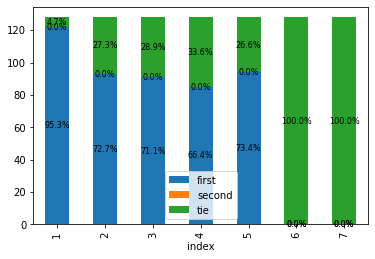

In [153]:
plotting_depth_of_fun2(trivial_heuristics, trivial_heuristics, size=3, max_depth2=7, depth1=7)

**WNIOSKI**

**Głębkość ma znaczenie przy wykorzystaniu algorytmu**. Gracz pierwszy gra z większą głębkością, przy kolejnych iteracjach gracza drugiego widać, że przewagę ma gracz pierwszy (Krzyżyk), ma on większą głębokość.


Diagramy funkcji plotting_depth_of_fun1 oraz plotting_depth_of_fun2 nie dają takich samych wyników, dlatego że ma znaczenie który gracz rozpoczyna rozgrywkę, żeby móc porównywać do siebie strategie będę testować obie heurestyki w taki sposób, że 50% rozgrywek będzie zaczynać pierwsza, a kolejne 50% druga heurystyka.


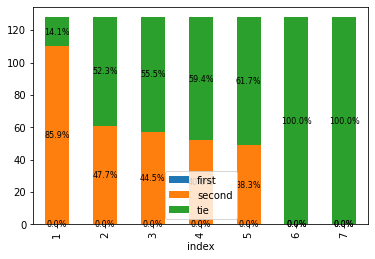

In [154]:
plotting_depth_symetric(trivial_heuristics, trivial_heuristics, size=3, max_depth1=7, depth2=7)

**WNIOSKI**


Przy tej samej heurystyce, gracz drugi grający z większą głębokością wygrywa znacznie więcej gier przy pierwszych iteracjach.
Przy końcowych iteracjach wyniki gier dla obydwu graczy zostały zremisowane, co oznacza że ruchy graczy(strategie) są optymalne lub bliskie optymalnego.




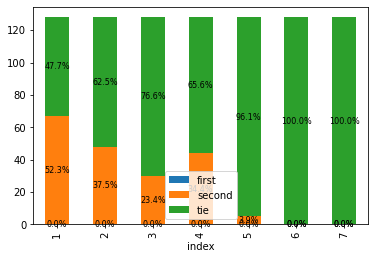

In [155]:
plotting_depth_symetric(heuristics, heuristics, size=3, max_depth1=7, depth2=7)

**WNIOSKI**

Przy korzystaniu z kolejnej funkcji **heuristic**, gracz drugi gra ze stałą głębokością równą 7. Przy pierwszych iteracjach widzimy jego przewagę nad graczem pierwszym. Na głębokości 6 oraz 7 gracze remisują.







,first,second,tie
index,,,
1,0,73,55
2,0,0,128
3,0,8,120
4,0,30,98
5,0,0,128
6,0,0,128
7,0,0,128


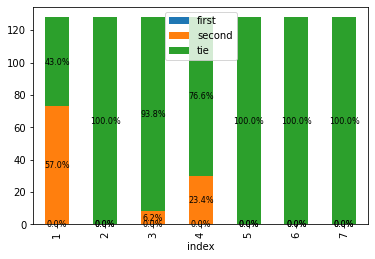

In [175]:
plotting_depth_symetric(heuristics2, heuristics2, size=3, max_depth1=7, depth2=7, disp=True)

**Wnioski**


Przy korzystaniu z kolejnej funkcji **heuristic2**, gracz drugi gra ze stałą głębokością równą 7 na planszy 3 na 3. Przy pierwszych iteracjach widzimy jego przewagę nad graczem pierwszym. Na głębokości 2, 5, 6 oraz 7 gracze remisują.


,first,second,tie
index,,,
1,0,71,57
2,0,42,86
3,0,22,106
4,0,43,85
5,0,0,128
6,0,0,128
7,0,0,128


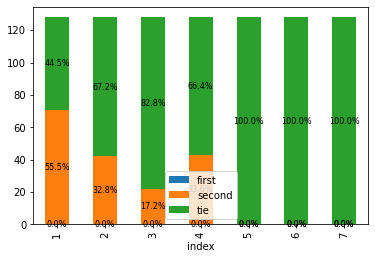

In [157]:
plotting_depth_symetric(heuristics, trivial_heuristics, size=3, max_depth1=7, depth2=7, disp=True)

**Wnioski**

Przy porównaniu dwóch róznych funkcji heurystycznych, nadal widać przewagę gracza drugiego nad graczem pierwszym, głębokość przeszukiwania nadal ma znaczenie, nawet przy słabszej heurystyce.

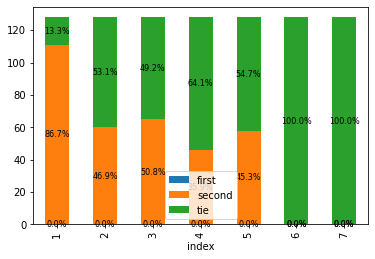

In [158]:
plotting_depth_symetric(trivial_heuristics, heuristics, size=3, max_depth1=7, depth2=7)

**Wnioski**

W tym przypadku wyrazniej widać przewagę funkcji heurystycznej heuristic nad funkcja trivial_heuristic. Więcej gier gracza drugiego zostały wygrane w porównaniu do wcześniejszego diagramu, wygrane przeciągnęły się do 5 głębokości, a po niej mamy remisy.

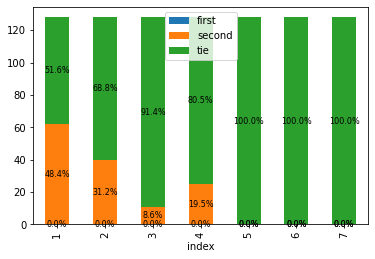

In [159]:
plotting_depth_symetric(heuristics2, trivial_heuristics, size=3, max_depth1=7, depth2=7)

**Wnioski**

Przy porównaniu dwóch róznych funkcji heurystycznych, nadal widać przewagę gracza drugiego nad graczem pierwszym. Drugi gra z większą głębokością przeszukiwania.



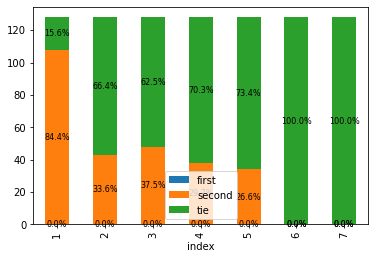

In [160]:
plotting_depth_symetric(trivial_heuristics, heuristics2, size=3, max_depth1=7, depth2=7)

**Wnioski**

Przy porównaniu dwóch róznych funkcji heurystycznych, nadal widać przewagę gracza drugiego nad graczem pierwszym. Gracz drugi gra z większą głębokością, ilość wygranych jest większa ze względu na wykorzystanie bardziej optymalnej funkcji heurystycznej.


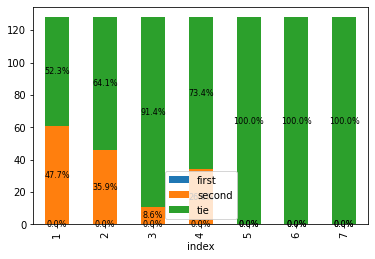

In [161]:
plotting_depth_symetric(heuristics2, heuristics, size=3, max_depth1=7, depth2=7)

**Wnioski**

Gracz drugi przy korzystaniu z funkcji heuristics oraz z większą głębokością ma przewagę nad graczem pierwszym. Przy końcowych głębokościach gracze remisują (5,6,7).



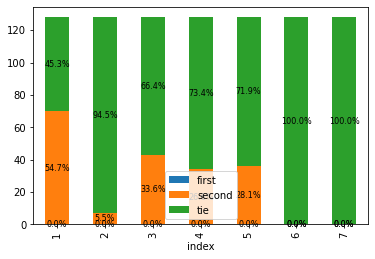

In [162]:
plotting_depth_symetric(heuristics, heuristics2, size=3, max_depth1=7, depth2=7)

**Wnioski**

Gracz drugi (Kółko) gra z bardziej korzystną heurystyką oraz z większą głębokością. 
Gracz pierwszy nie ma szans na wygraną przy takich ustawieniach. W porównaniu do poprzedniego wykresu ilość wygranych gracz drugiego jest znacznie większa. Widać, że dla głębokości 5 gracz drugi ma nadal korzystniejsze wyniki, nie remisuje tak jak na poprzednim wykresie.

In [144]:
def no_heuristics(*a):
    assert 0

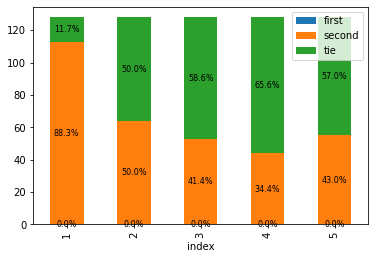

In [150]:
plotting_depth_symetric(trivial_heuristics, no_heuristics, size=3, max_depth1=5, depth2=np.inf)

**Wnioski**

Przewaga gracza drugiego we wszystkich głębokościach, osiągającego stan terminalny.

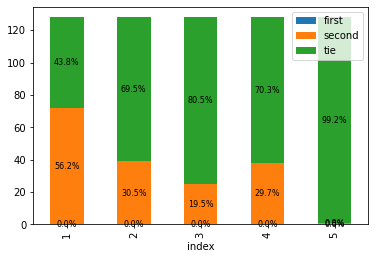

In [176]:
plotting_depth_symetric(heuristics, no_heuristics, size=3, max_depth1=5, depth2=np.inf)

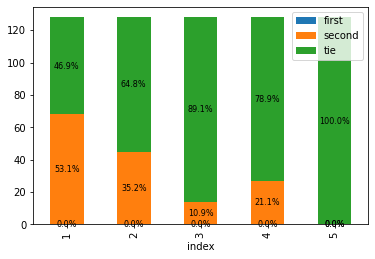

In [178]:
plotting_depth_symetric(heuristics2, no_heuristics, size=3, max_depth1=5, depth2=np.inf)

**Wnioski**

Diagramy dla głębokości osiągających stan terminalny dla gracza drugiego, gracz drugi ma większą szanse na wygraną.
Dla głębokości 5 funkcja heuristics2 remisuje rozgrywkę, co znaczy że jest optymalna.

### Wyniki turniejowe dla większych plansz

,first,second,tie
index,,,
1,1,69,58
2,3,8,117
3,1,13,114
4,1,0,127


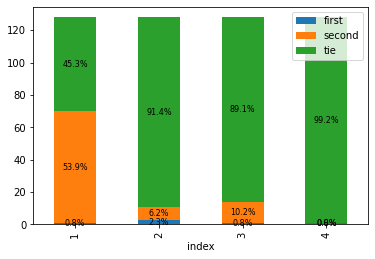

In [174]:
plotting_depth_symetric(trivial_heuristics, trivial_heuristics, size=4, max_depth1=4, depth2=4, disp=True)

**Wnioski**

Gracz drugi, który gra przy pomocy większej głębokości przeszukiwania ma większe szanse na wygraną przy zwiększaniu się kolejnych głębokości gracza pierwszego. Zauważamy minimalne szanse na wygraną dla gracza pierwszego przy zwiększaniu rozmiaru planszy, rzędu 1%.

,first,second,tie
index,,,
1,1,19,108
2,0,3,125
3,0,7,121
4,1,3,124


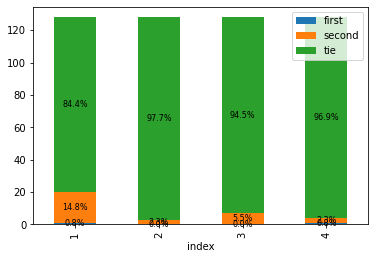

In [165]:
plotting_depth_symetric(heuristics, heuristics, size=4, max_depth1=4, depth2=4, disp=True)

**Wnioski**

Gracz drugi, który gra przy pomocy większej głębokości przeszukiwania ma większe szanse na wygraną przy zwiększaniu się kolejnych głębokości gracza pierwszego.
W porównaniu do funkcji trivial_heuristic gracz drugi, wygrywał o wiele mniej razy.


,first,second,tie
index,,,
1,0,8,120
2,1,4,123
3,0,3,125
4,5,0,123


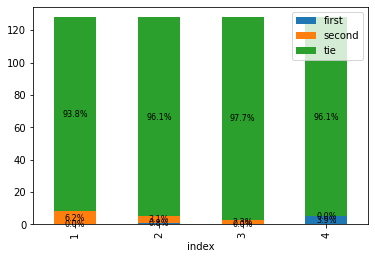

In [166]:
plotting_depth_symetric(heuristics, trivial_heuristics, size=4, max_depth1=4, depth2=4, disp=True)

**wnioski**

Gracz drugi korzystający z większej głębokości wygrywa wraz ze wzrostem głębokości gracza pierwszego. Przy osiągnieciu tej samej głębokości gracz pierwszy korzystający z bardziej optymalnej heurystyki wygrał więcej razy, co świadczy o tym, że funkcja heurystyczna którą implementują gracze ma znaczenie.

,first,second,tie
index,,,
1,0,81,47
2,1,16,111
3,0,11,117
4,0,3,125


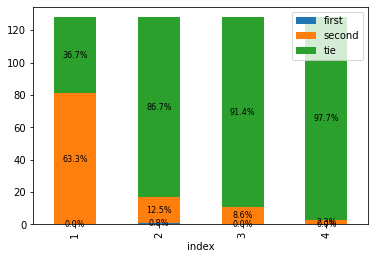

In [167]:
plotting_depth_symetric(trivial_heuristics, heuristics, size=4, max_depth1=4, depth2=4, disp=True)

**Wnioski**

Gracz drugi przy bardziej korzystnej heurystyce oraz większej głębokości ma większe szanse na wygraną. W porównaniu do wcześniejszego wykresu ilość wygranych jest większa.

,first,second,tie
index,,,
1,0,43,85
2,0,4,124
3,0,4,124
4,1,1,126


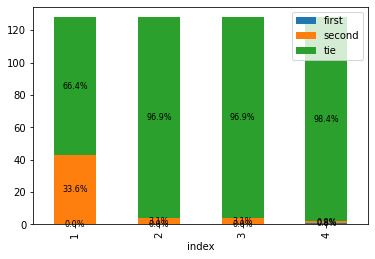

In [168]:
plotting_depth_symetric(trivial_heuristics, trivial_heuristics, size=5, max_depth1=4, depth2=4, disp=True)

**Wnioski**

Gracz drugi przy większej głębokości ma większe szanse na wygraną. Przy równych głębokościach następuje remis dla obydwu graczy. Gra rozegrana na planszy 5 na 5.

,first,second,tie
index,,,
1,0,60,68
2,0,3,125
3,0,0,128
4,0,0,128


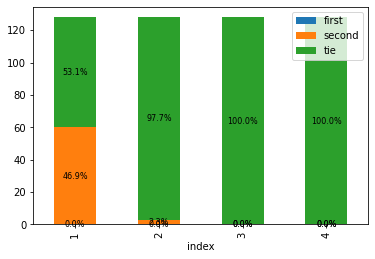

In [169]:
plotting_depth_symetric(trivial_heuristics, heuristics, size=5, max_depth1=4, depth2=4, disp=True)

**Wnioski**

Gracz drugi wygrywa, duże znaczenie dla strategi mają zastosowane heurystyki. Na większej planszy 5x5 liczba remisów jest znacznie większa, co widać na 3 i 4 głębokości.

,first,second,tie
index,,,
1,0,0,128
2,0,0,128
3,0,0,128
4,0,0,128


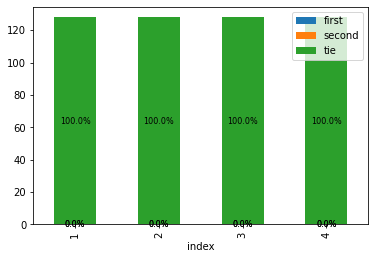

In [130]:
plotting_depth_symetric(heuristics, trivial_heuristics, size=5, max_depth1=4, depth2=4, disp=True)

**Wnioski**

Uzyskany remis dla wszystkich głębokości. Przy większych planszach i obecnych ostawieniach (wygrywa cały zapełniony rząd diagonal, kolumn, wierszy) wartość remisów jest najbardziej prawdopodobna.